# LoRa SOM - 올바른 거리 공간에서의 분석

## 핵심 인사이트

LoRa 심볼의 본질:
- Dechirp 후 각 심볼은 **고유한 주파수의 순수 톤**
- 심볼 간 거리 = **주파수 인덱스의 순환적 거리**

```
Symbol k → Frequency bin k (after dechirp)
d(0, 1) = 1
d(0, 256) = 256 (최대)
d(0, 511) = 1 (순환: 512-511=1)
```

## 접근 방법
1. **원형 좌표**: 심볼 인덱스를 (cos, sin)으로 변환
2. **커스텀 거리**: 순환적 거리 함수 사용

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.signal import stft
import warnings
warnings.filterwarnings('ignore')

def _add_project_root_to_syspath() -> Path | None:
    here = Path.cwd().resolve()
    for p in (here, *here.parents):
        if (p / "utils" / "LoRa.py").exists():
            sys.path.insert(0, str(p))
            return p
    return None

PROJECT_ROOT = _add_project_root_to_syspath()
if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate project root containing utils/LoRa.py")

from som import SelfOrganizingMap
from utils.LoRa import LoRa

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("모듈 임포트 완료!", "PROJECT_ROOT=", PROJECT_ROOT)

모듈 임포트 완료! PROJECT_ROOT= /home/gwon9906/self-organizing-map


## 1. LoRa 심볼 생성 및 분석

In [2]:
SF = 9
BW = 125e3
OSF = 1

lora = LoRa(sf=SF, bw=BW, OSF=OSF)
num_symbols = 2 ** SF

# 심볼 생성
symbols = np.array([lora.gen_symbol(i) for i in range(num_symbols)])
labels = np.arange(num_symbols)

print(f"SF = {SF}, 심볼 개수 = {num_symbols}")

SF = 9, 심볼 개수 = 512


In [3]:
# Dechirp 후 FFT 피크 위치 확인
peak_indices = []
for s in symbols:
    dechirped = lora.dechirp(s)
    fft_mag = np.abs(np.fft.fft(dechirped))
    peak_indices.append(np.argmax(fft_mag))

peak_indices = np.array(peak_indices)
print(f"피크 인덱스 == 심볼 인덱스: {np.all(peak_indices == labels)}")

피크 인덱스 == 심볼 인덱스: True


## 2. 원형 좌표 변환

심볼 인덱스 k를 2D 원형 좌표로:
```
θ = 2π × k / N
x = cos(θ)
y = sin(θ)
```

원형 좌표 shape: (512, 2)


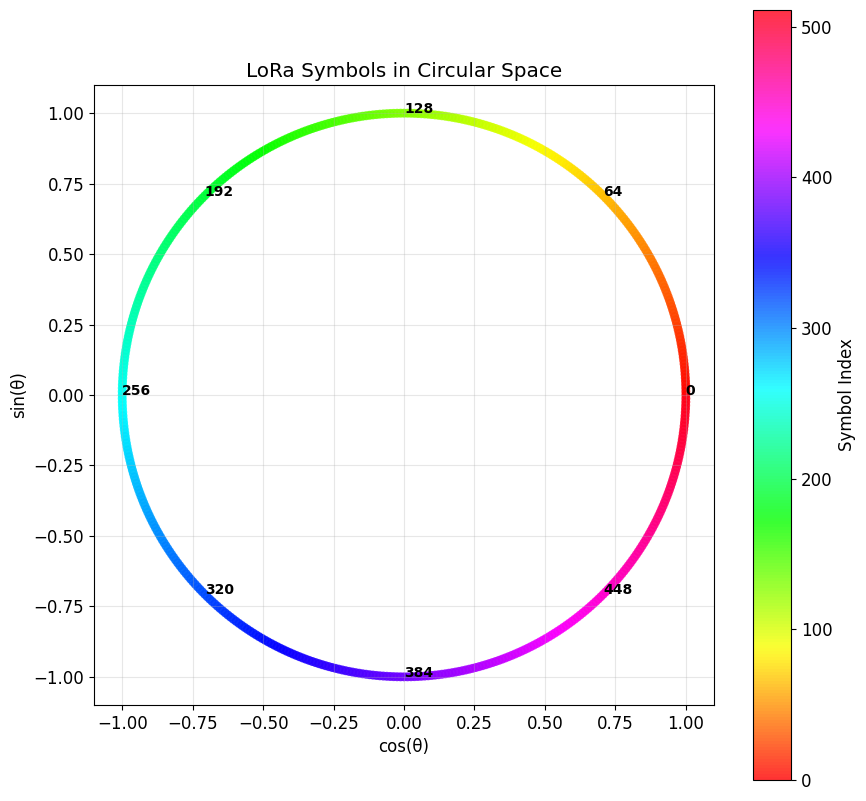

In [4]:
# 원형 좌표 생성
angles = 2 * np.pi * labels / num_symbols
circular_coords = np.column_stack([np.cos(angles), np.sin(angles)])

print(f"원형 좌표 shape: {circular_coords.shape}")

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(circular_coords[:, 0], circular_coords[:, 1], 
                     c=labels, cmap='hsv', s=30, alpha=0.8)
plt.colorbar(scatter, label='Symbol Index')

# 일부 심볼 라벨
for idx in [0, 64, 128, 192, 256, 320, 384, 448]:
    ax.annotate(f'{idx}', circular_coords[idx], fontsize=10, fontweight='bold')

ax.set_xlabel('cos(θ)')
ax.set_ylabel('sin(θ)')
ax.set_title('LoRa Symbols in Circular Space')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()

In [5]:
# 원형 좌표에서의 유클리드 거리 = 순환적 거리와 비례
print("원형 좌표에서의 유클리드 거리:")
for idx in [1, 10, 100, 256, 511]:
    d = np.linalg.norm(circular_coords[0] - circular_coords[idx])
    circular_d = min(idx, num_symbols - idx)  # 순환 거리
    print(f"  d(0, {idx:3d}) = {d:.4f}  (순환거리: {circular_d})")

원형 좌표에서의 유클리드 거리:
  d(0,   1) = 0.0123  (순환거리: 1)
  d(0,  10) = 0.1226  (순환거리: 10)
  d(0, 100) = 1.1516  (순환거리: 100)
  d(0, 256) = 2.0000  (순환거리: 256)
  d(0, 511) = 0.0123  (순환거리: 1)


## 3. SOM 학습 - 원형 좌표

In [6]:
# 정규화 (원형 좌표는 이미 [-1, 1] 범위)
data = circular_coords.copy()

# SOM 파라미터
MAP_SIZE = (32, 32)  # 충분히 큰 맵
SIGMA = 16
LR = 0.5
ITERATIONS = 100000

print(f"SOM 설정: {MAP_SIZE}, σ={SIGMA}, lr={LR}, iter={ITERATIONS}")

SOM 설정: (32, 32), σ=16, lr=0.5, iter=100000


In [7]:
# SOM 생성 및 학습
som = SelfOrganizingMap(
    map_size=MAP_SIZE,
    input_dim=2,
    sigma=SIGMA,
    learning_rate=LR,
    distance_fn='euclidean',
    random_seed=42
)

# 데이터 기반 초기화
som.init_weights_from_data(data)

print("SOM 학습 시작...\n")
som.train(data, ITERATIONS, verbose=True)
print("\n완료!")

SOM 학습 시작...

Iteration 10000/100000 - QE: 0.3074, TE: 0.0000, LR: 0.4524, σ: 12.0528
Iteration 20000/100000 - QE: 0.1552, TE: 0.0000, LR: 0.4094, σ: 9.0791
Iteration 30000/100000 - QE: 0.0893, TE: 0.1074, LR: 0.3704, σ: 6.8391
Iteration 40000/100000 - QE: 0.0495, TE: 0.2363, LR: 0.3352, σ: 5.1517
Iteration 50000/100000 - QE: 0.0251, TE: 0.3398, LR: 0.3033, σ: 3.8807
Iteration 60000/100000 - QE: 0.0133, TE: 0.5000, LR: 0.2744, σ: 2.9232
Iteration 70000/100000 - QE: 0.0082, TE: 0.6113, LR: 0.2483, σ: 2.2020
Iteration 80000/100000 - QE: 0.0055, TE: 0.5625, LR: 0.2247, σ: 1.6587
Iteration 90000/100000 - QE: 0.0043, TE: 0.5898, LR: 0.2033, σ: 1.2495
Iteration 100000/100000 - QE: 0.0033, TE: 0.6152, LR: 0.1839, σ: 0.9412

완료!


## 4. 결과 시각화

In [8]:
# BMU 계산
bmu_positions = np.array([som.predict(x) for x in data])

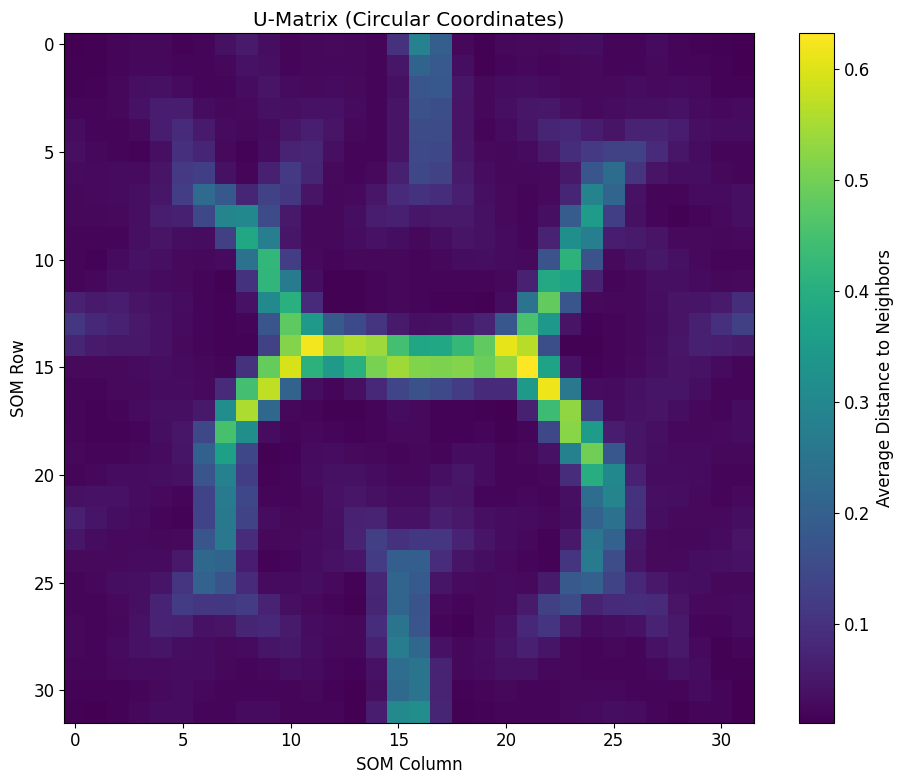

In [9]:
# U-Matrix
fig, ax = som.plot_u_matrix(figsize=(10, 8))
plt.title('U-Matrix (Circular Coordinates)')
plt.show()

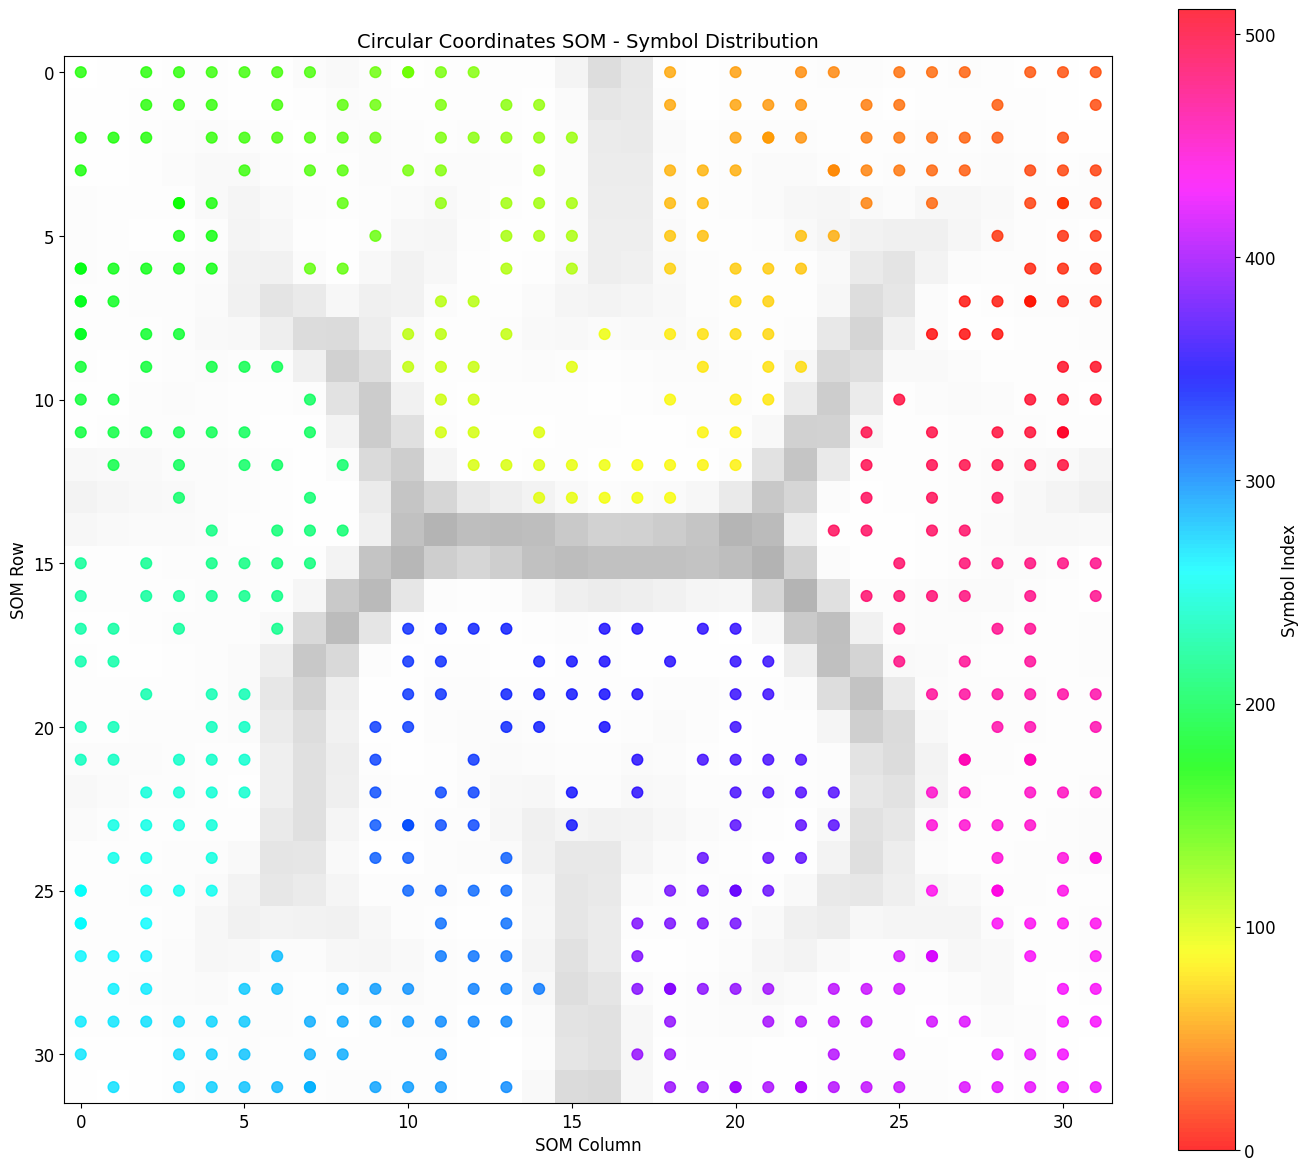

In [10]:
# 심볼 분포
fig, ax = plt.subplots(figsize=(14, 12))

u_matrix = som.get_u_matrix()
ax.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')

# jitter 없이 정확한 위치
scatter = ax.scatter(
    bmu_positions[:, 1],
    bmu_positions[:, 0],
    c=labels, cmap='hsv', alpha=0.8, s=60
)
plt.colorbar(scatter, label='Symbol Index')

ax.set_xlim(-0.5, MAP_SIZE[1]-0.5)
ax.set_ylim(MAP_SIZE[0]-0.5, -0.5)
ax.set_title('Circular Coordinates SOM - Symbol Distribution', fontsize=14)
ax.set_xlabel('SOM Column')
ax.set_ylabel('SOM Row')
plt.tight_layout()
plt.show()

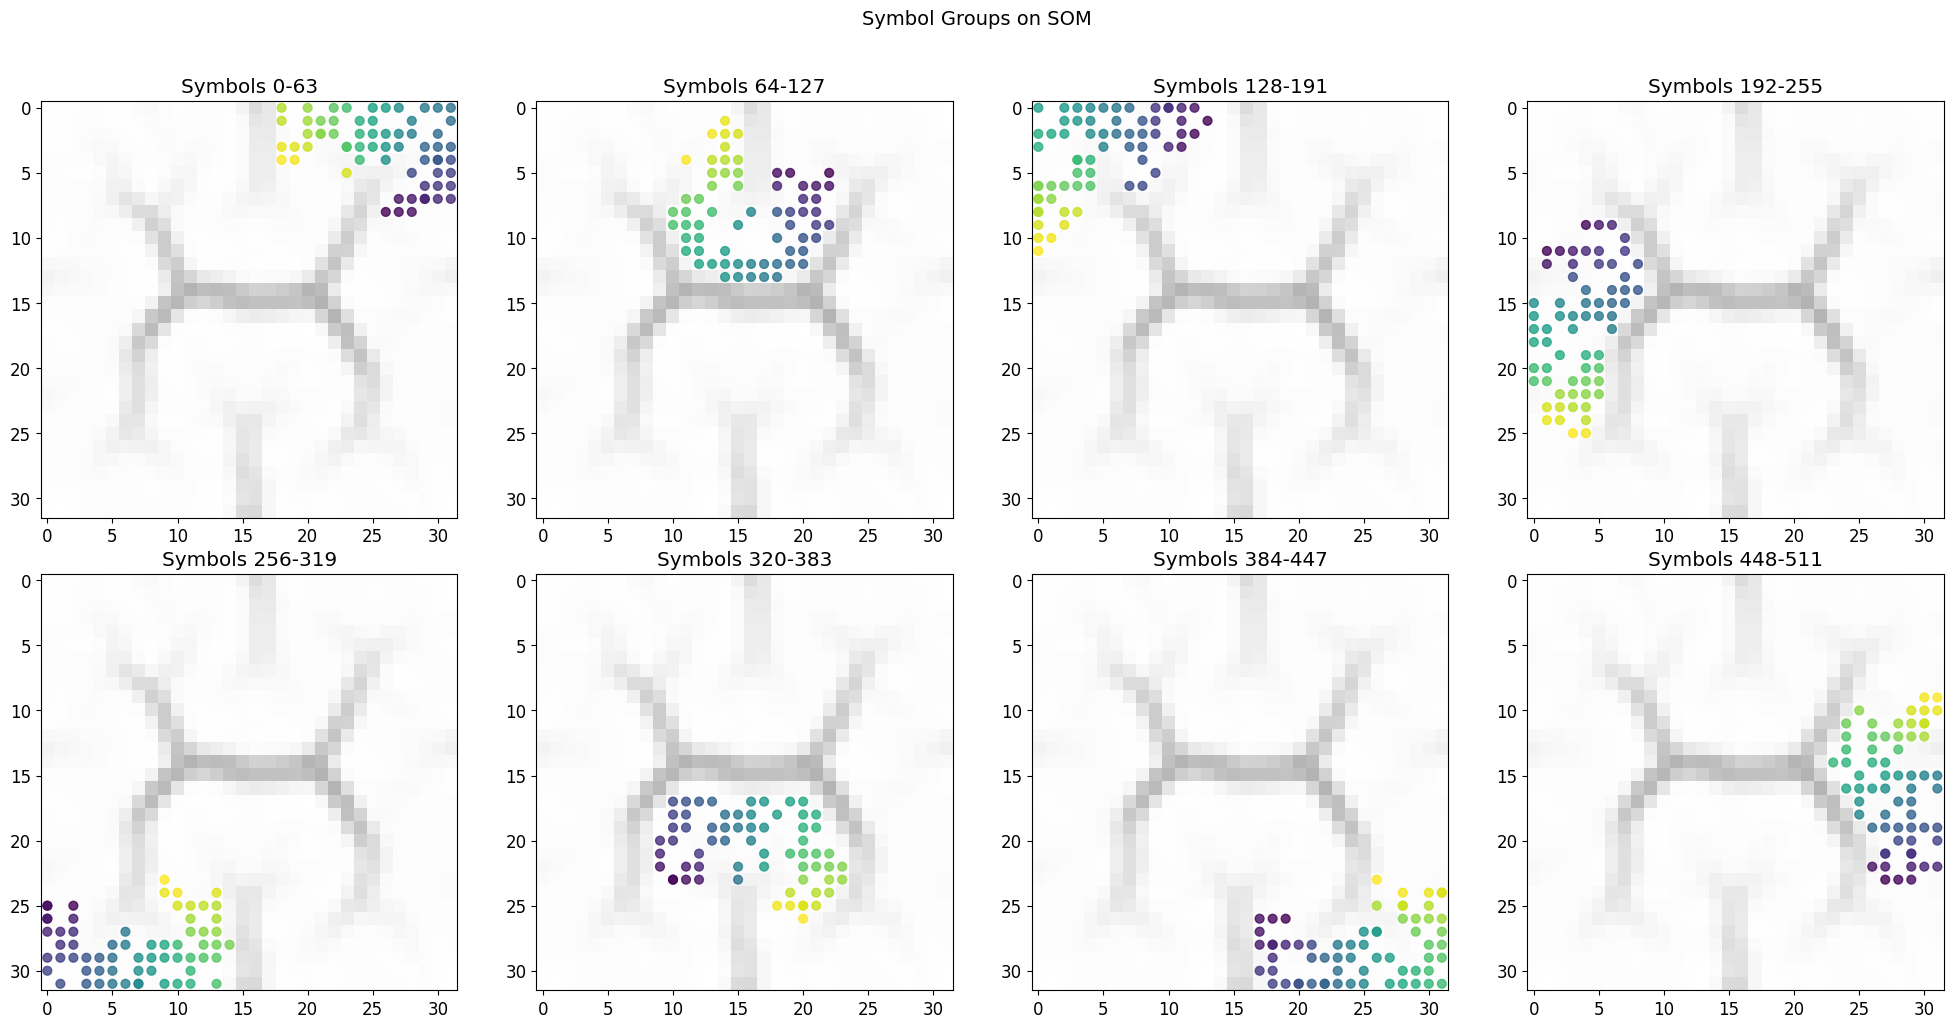

In [11]:
# 그룹별 시각화
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

group_size = num_symbols // 8

for i, ax in enumerate(axes.flat):
    start_idx = i * group_size
    end_idx = (i + 1) * group_size
    
    ax.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
    
    mask = (labels >= start_idx) & (labels < end_idx)
    group_bmu = bmu_positions[mask]
    group_labels = labels[mask]
    
    sc = ax.scatter(
        group_bmu[:, 1],
        group_bmu[:, 0],
        c=group_labels, cmap='viridis', alpha=0.8, s=40
    )
    ax.set_xlim(-0.5, MAP_SIZE[1]-0.5)
    ax.set_ylim(MAP_SIZE[0]-0.5, -0.5)
    ax.set_title(f'Symbols {start_idx}-{end_idx-1}')

plt.suptitle('Symbol Groups on SOM', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. 토폴로지 분석

In [12]:
# 연속 심볼 간 BMU 거리
consecutive_distances = []
for i in range(num_symbols):
    next_i = (i + 1) % num_symbols
    d = np.sqrt((bmu_positions[i,0] - bmu_positions[next_i,0])**2 + 
                (bmu_positions[i,1] - bmu_positions[next_i,1])**2)
    consecutive_distances.append(d)

consecutive_distances = np.array(consecutive_distances)

print("연속 심볼 간 BMU 거리:")
print(f"  평균: {consecutive_distances.mean():.3f}")
print(f"  표준편차: {consecutive_distances.std():.3f}")
print(f"  최소: {consecutive_distances.min():.3f}")
print(f"  최대: {consecutive_distances.max():.3f}")
print(f"  이웃(d≤√2) 비율: {(consecutive_distances <= np.sqrt(2)).mean()*100:.1f}%")

연속 심볼 간 BMU 거리:
  평균: 1.749
  표준편차: 1.085
  최소: 0.000
  최대: 5.831
  이웃(d≤√2) 비율: 59.8%


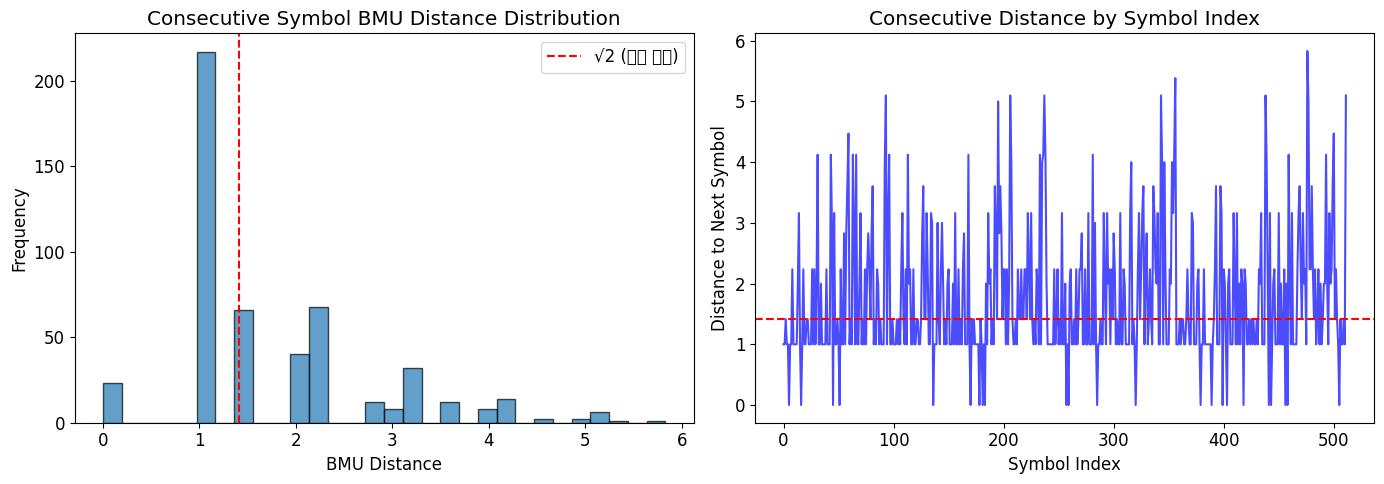

In [13]:
# 거리 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(consecutive_distances, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(np.sqrt(2), color='red', linestyle='--', label='√2 (인접 기준)')
axes[0].set_xlabel('BMU Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Consecutive Symbol BMU Distance Distribution')
axes[0].legend()

axes[1].plot(consecutive_distances, 'b-', alpha=0.7)
axes[1].axhline(np.sqrt(2), color='red', linestyle='--')
axes[1].set_xlabel('Symbol Index')
axes[1].set_ylabel('Distance to Next Symbol')
axes[1].set_title('Consecutive Distance by Symbol Index')

plt.tight_layout()
plt.show()

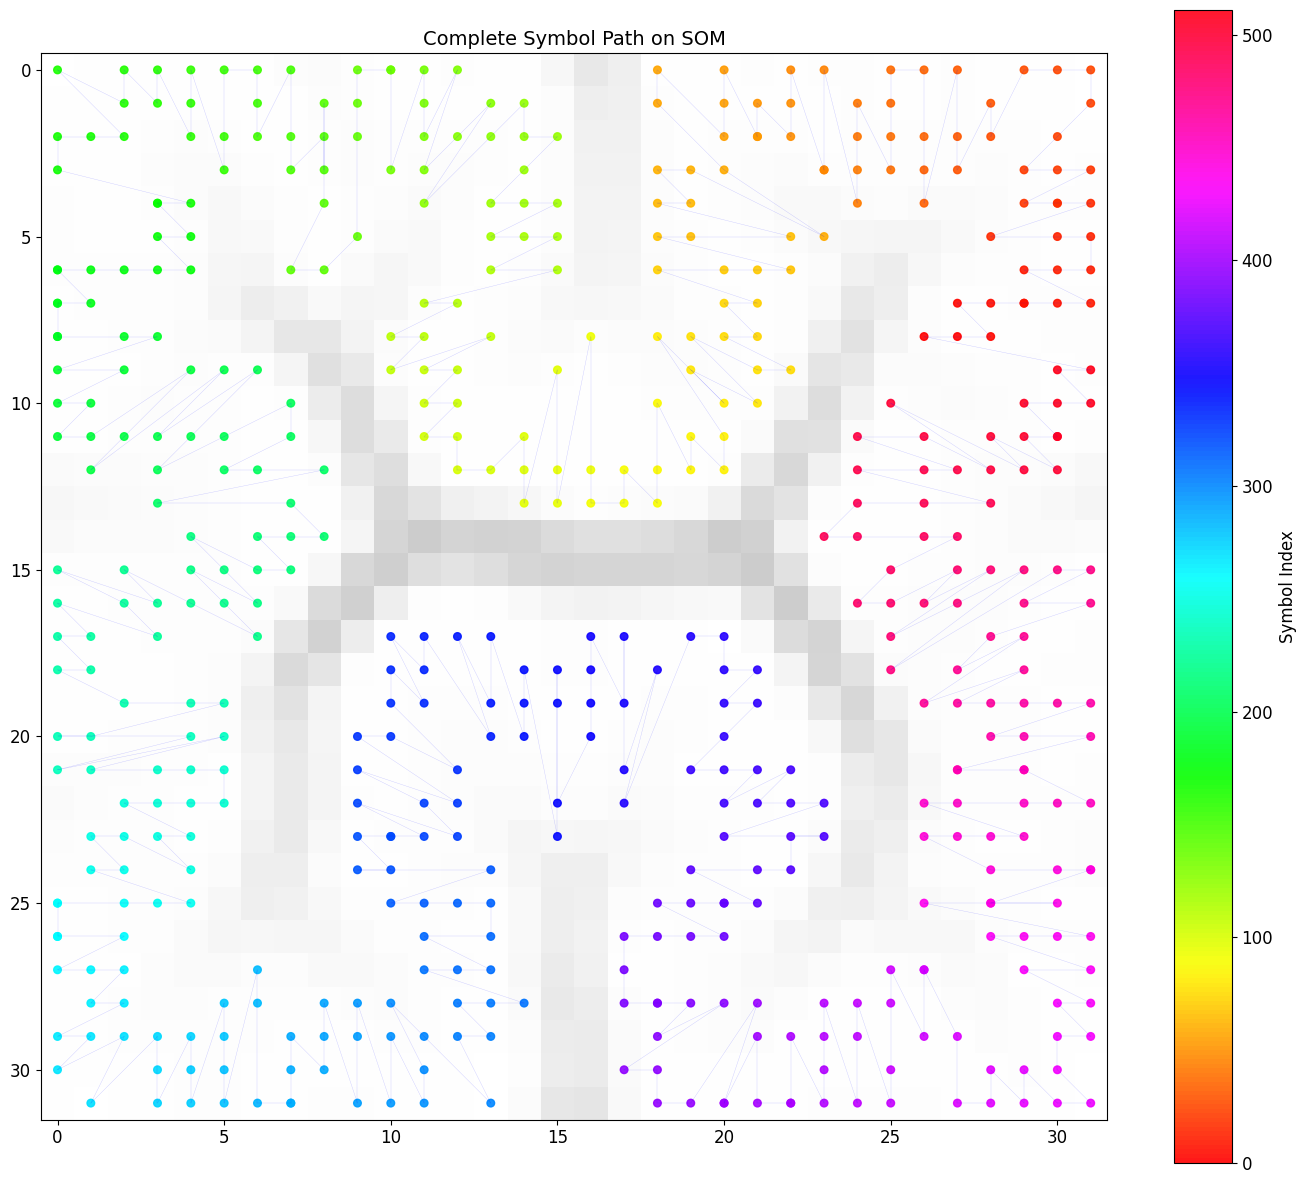

In [14]:
# 심볼 경로 (전체)
fig, ax = plt.subplots(figsize=(14, 12))

ax.imshow(u_matrix, cmap='gray_r', alpha=0.2, interpolation='nearest')

# 모든 연결선
for i in range(num_symbols):
    next_i = (i + 1) % num_symbols
    ax.plot([bmu_positions[i,1], bmu_positions[next_i,1]], 
            [bmu_positions[i,0], bmu_positions[next_i,0]], 
            'b-', alpha=0.2, lw=0.3)

scatter = ax.scatter(
    bmu_positions[:, 1],
    bmu_positions[:, 0],
    c=labels, cmap='hsv', s=30, alpha=0.9
)
plt.colorbar(scatter, label='Symbol Index')

ax.set_xlim(-0.5, MAP_SIZE[1]-0.5)
ax.set_ylim(MAP_SIZE[0]-0.5, -0.5)
ax.set_title('Complete Symbol Path on SOM', fontsize=14)
plt.tight_layout()
plt.show()

## 6. 최종 결과

In [15]:
print("="*60)
print("최종 결과")
print("="*60)

print(f"\nQuantization Error: {som.quantization_error(data):.6f}")
print(f"Topographic Error: {som.topographic_error(data):.4f}")
print(f"연속 심볼 평균 BMU 거리: {consecutive_distances.mean():.3f}")
print(f"연속 심볼 이웃 비율: {(consecutive_distances <= np.sqrt(2)).mean()*100:.1f}%")

print("\n" + "="*60)
print("해석:")
print("- 원형 좌표는 심볼의 순환적 특성을 2D로 정확히 표현")
print("- 유클리드 거리가 심볼 간 실제 거리와 비례")
print("- 토폴로지 보존 = 색상 그라데이션 + 낮은 연속 심볼 거리")
print("="*60)

최종 결과

Quantization Error: 0.003281
Topographic Error: 0.6152
연속 심볼 평균 BMU 거리: 1.749
연속 심볼 이웃 비율: 59.8%

해석:
- 원형 좌표는 심볼의 순환적 특성을 2D로 정확히 표현
- 유클리드 거리가 심볼 간 실제 거리와 비례
- 토폴로지 보존 = 색상 그라데이션 + 낮은 연속 심볼 거리


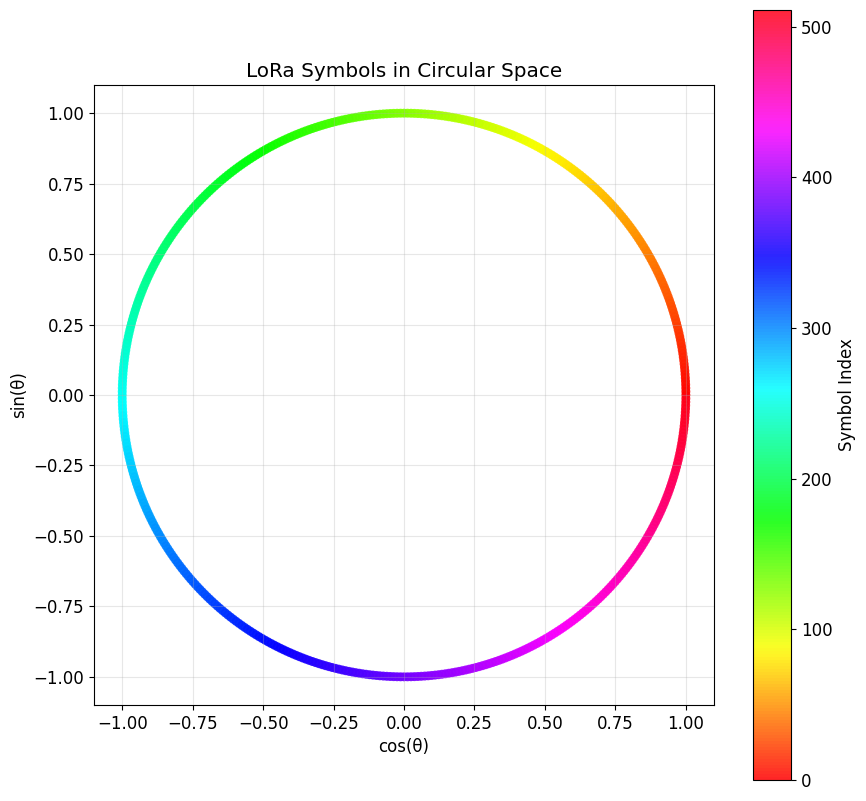

Saved: /home/gwon9906/self-organizing-map/docs/assets/circular_space.png


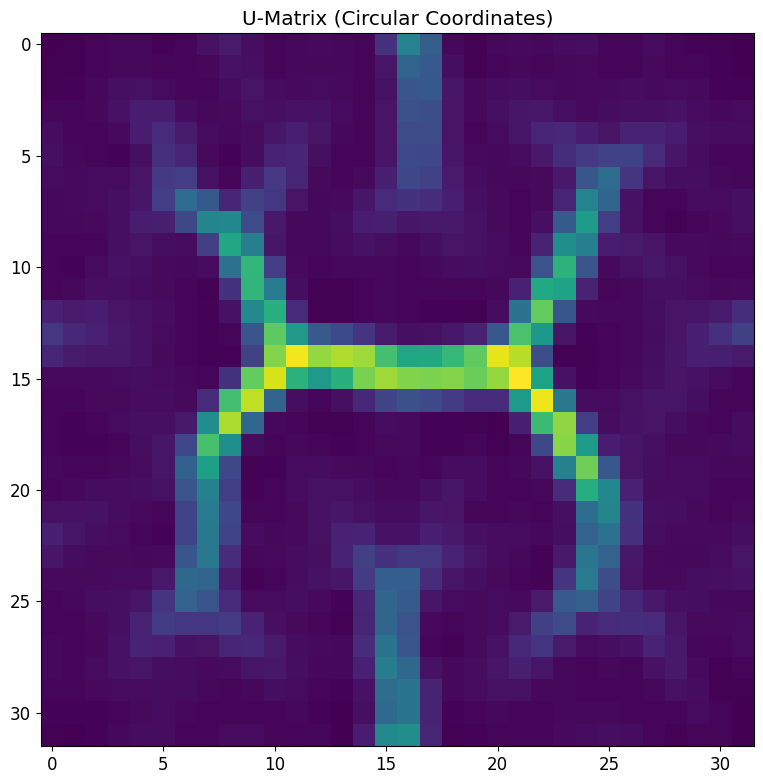

Saved: /home/gwon9906/self-organizing-map/docs/assets/circular_u_matrix.png


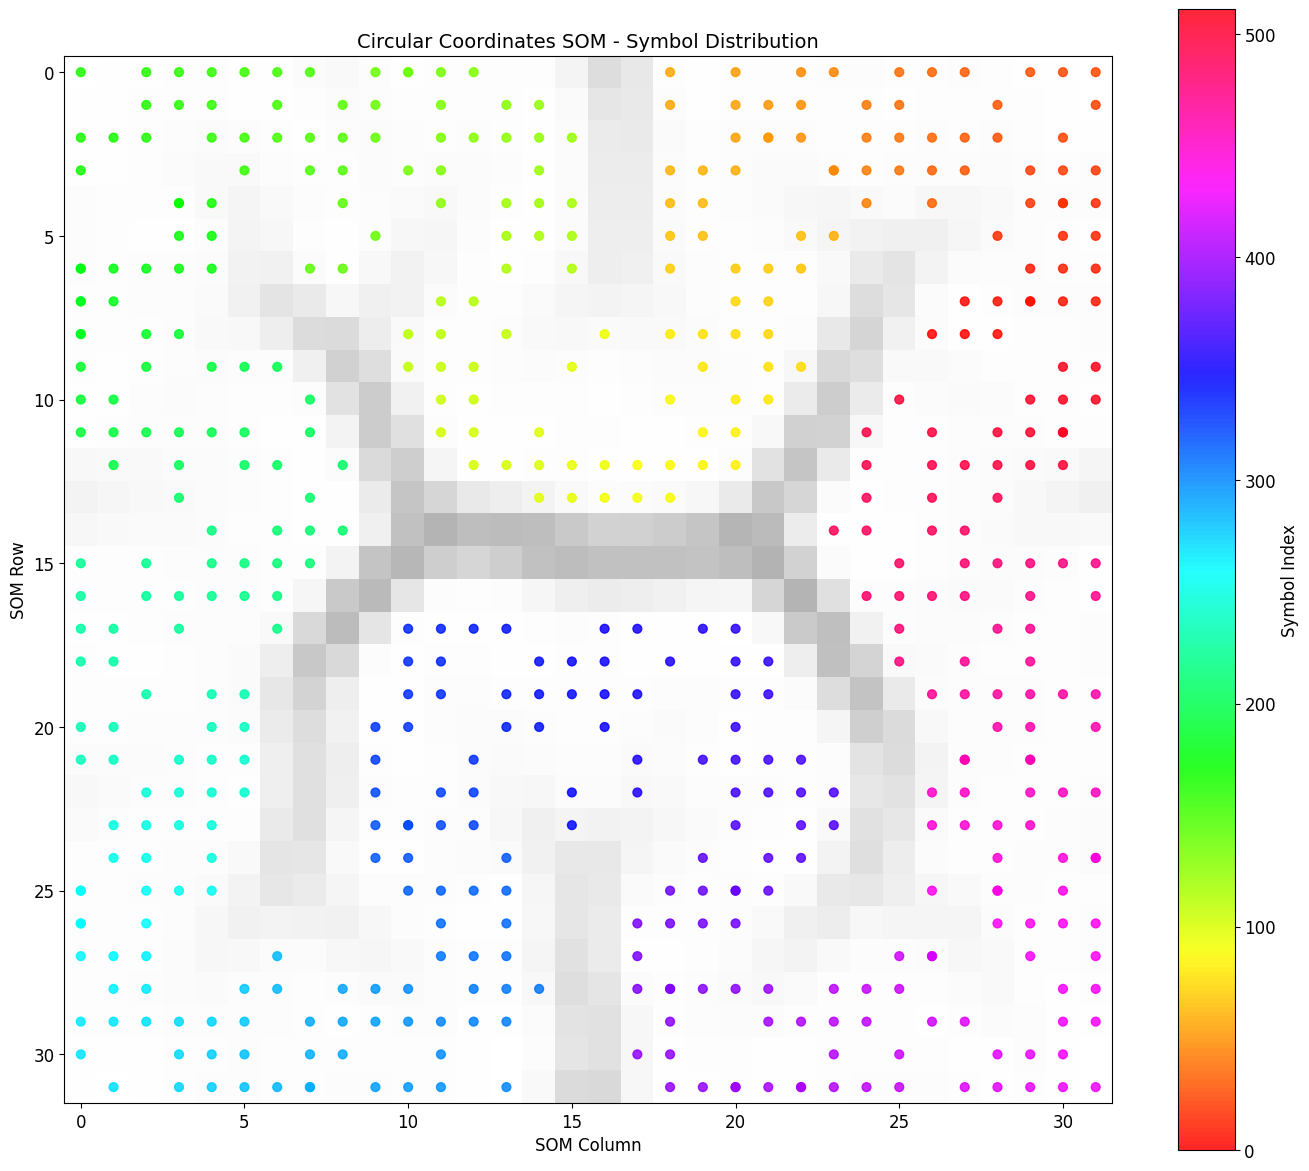

Saved: /home/gwon9906/self-organizing-map/docs/assets/circular_symbol_distribution.png


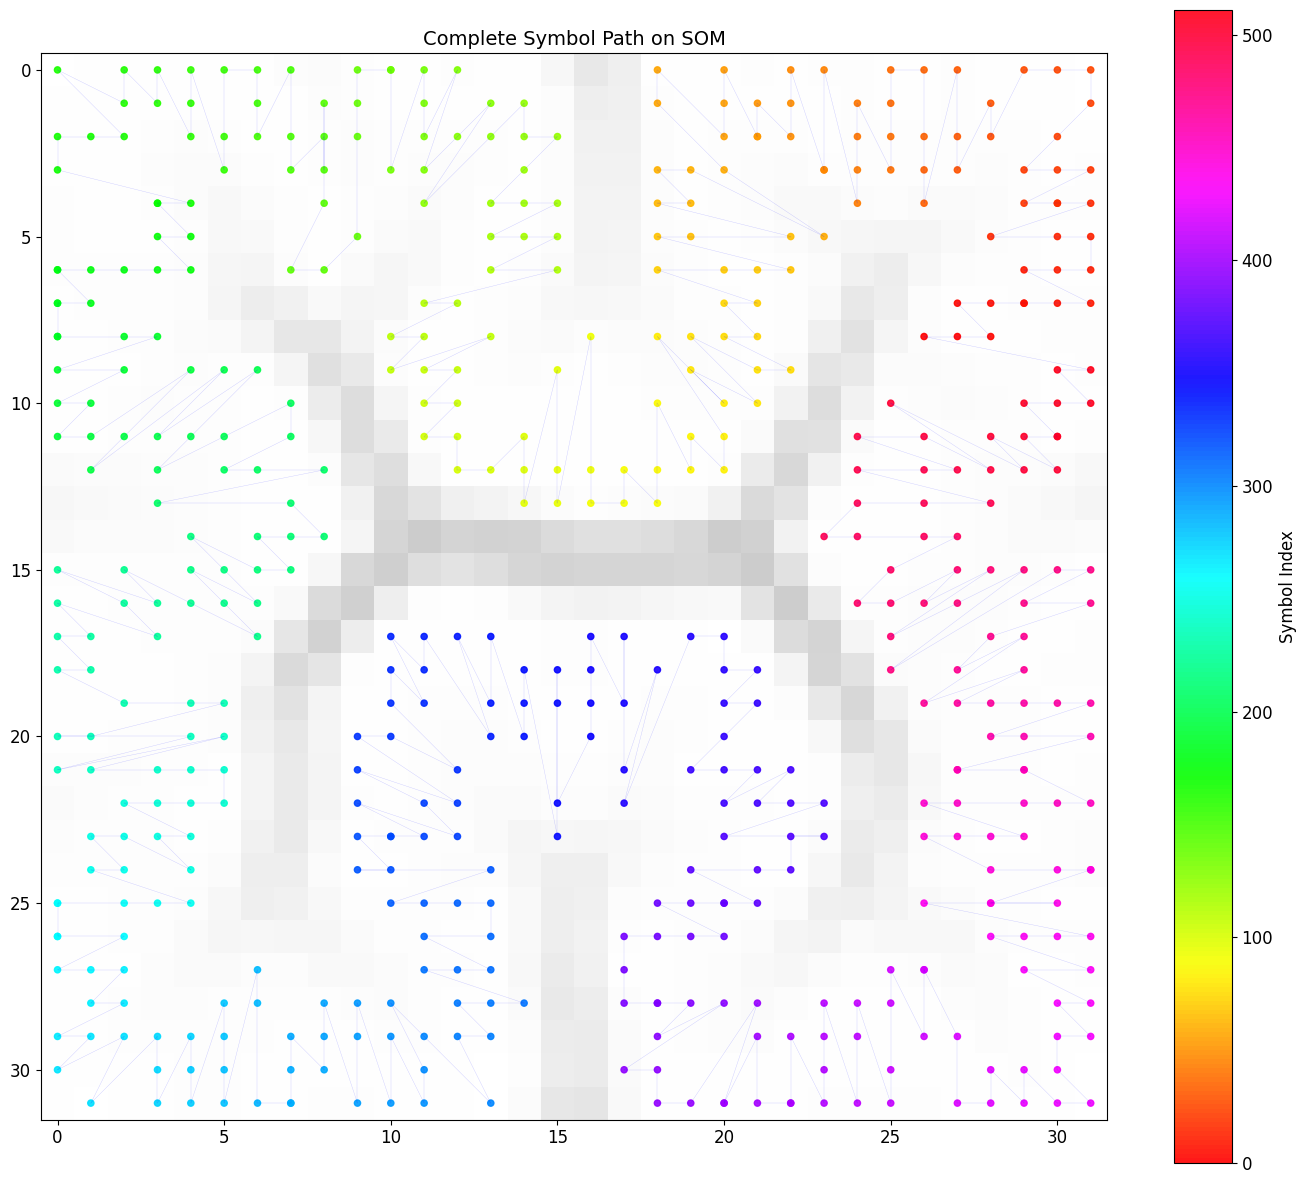

Saved: /home/gwon9906/self-organizing-map/docs/assets/circular_symbol_path.png


In [16]:
# 결과 이미지 저장 (repo/docs/assets)
from pathlib import Path
import numpy as np

def _find_repo_root() -> Path:
    here = Path.cwd().resolve()
    for p in (here, *here.parents):
        if (p / "utils" / "LoRa.py").exists() and (p / "model-test" / "som.py").exists():
            return p
    return here

ROOT = _find_repo_root()
out_dir = ROOT / "docs" / "assets"
out_dir.mkdir(parents=True, exist_ok=True)

# 1) 원형 좌표(라벨 색) 산점도
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(circular_coords[:, 0], circular_coords[:, 1], c=labels, cmap='hsv', s=30, alpha=0.85)
plt.colorbar(sc, ax=ax, label='Symbol Index')
ax.set_xlabel('cos(θ)')
ax.set_ylabel('sin(θ)')
ax.set_title('LoRa Symbols in Circular Space')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

p1 = out_dir / "circular_space.png"
fig.savefig(p1, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {p1}")

# 2) U-Matrix
fig2, ax2 = plt.subplots(figsize=(10, 8))
ax2.imshow(u_matrix, cmap='viridis', interpolation='nearest')
ax2.set_title('U-Matrix (Circular Coordinates)')
plt.tight_layout()

p2 = out_dir / "circular_u_matrix.png"
fig2.savefig(p2, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {p2}")

# 3) 심볼 분포(라벨 색)
fig3, ax3 = plt.subplots(figsize=(14, 12))
ax3.imshow(u_matrix, cmap='gray_r', alpha=0.3, interpolation='nearest')
sc3 = ax3.scatter(
    bmu_positions[:, 1],
    bmu_positions[:, 0],
    c=labels, cmap='hsv', alpha=0.85, s=40,
)
plt.colorbar(sc3, ax=ax3, label='Symbol Index')
ax3.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
ax3.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
ax3.set_title('Circular Coordinates SOM - Symbol Distribution', fontsize=14)
ax3.set_xlabel('SOM Column')
ax3.set_ylabel('SOM Row')
plt.tight_layout()

p3 = out_dir / "circular_symbol_distribution.png"
fig3.savefig(p3, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {p3}")

# 4) 심볼 경로(전체 연결)
fig4, ax4 = plt.subplots(figsize=(14, 12))
ax4.imshow(u_matrix, cmap='gray_r', alpha=0.2, interpolation='nearest')
for i in range(num_symbols):
    ni = (i + 1) % num_symbols
    ax4.plot([bmu_positions[i, 1], bmu_positions[ni, 1]], [bmu_positions[i, 0], bmu_positions[ni, 0]], 'b-', alpha=0.2, lw=0.3)
sc4 = ax4.scatter(bmu_positions[:, 1], bmu_positions[:, 0], c=labels, cmap='hsv', s=20, alpha=0.9)
plt.colorbar(sc4, ax=ax4, label='Symbol Index')
ax4.set_xlim(-0.5, MAP_SIZE[1] - 0.5)
ax4.set_ylim(MAP_SIZE[0] - 0.5, -0.5)
ax4.set_title('Complete Symbol Path on SOM', fontsize=14)
plt.tight_layout()

p4 = out_dir / "circular_symbol_path.png"
fig4.savefig(p4, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {p4}")